In [1]:
%matplotlib notebook
import numpy as np
import glob, os, copy
from astropy.io import fits
from matplotlib import pyplot as plt
import time
from scipy.optimize import minimize
from scipy.stats import truncnorm
import emcee
import corner
from scipy.stats import skew

In [2]:
# ----- Structures ----- #
current_dir = os.getcwd()
dir_SFH = '/data/jlee/DATA/Tests/test_python/SFH_isjang/N300_SFH/1_N300_out/'
dir_obs = dir_SFH+'obs/'
dir_mod = dir_SFH+'models/'

In [3]:
# ----- Loading data ----- #

# The observed CMD
obs_cmd = fits.getdata(dir_obs+'F456.fits', header=False)
Y = obs_cmd.copy()
Y_sum = np.sum(Y)
S = np.sqrt(Y)
S[S==0] = 1.    # not this, but just placeholder
# S = np.sqrt(S**2 + detection_error**2 + minimal_error**2)
Y = Y/Y_sum
S = S/Y_sum
Y_shape = Y.shape

# Model CMDs ([Fe/H] = -1.60)
# model_list = glob.glob(dir_mod+'a*fehm1.60.fits')
# model_list = sorted(model_list)    # 6.6 - 10.0 Gyr w/ an interval of 0.1 Gyr
model_list = [dir_mod+'a07.00fehm1.60.fits', dir_mod+'a07.50fehm1.60.fits',
              dir_mod+'a08.00fehm1.60.fits', dir_mod+'a08.50fehm1.60.fits',
              dir_mod+'a09.00fehm1.60.fits', dir_mod+'a09.50fehm1.60.fits',
              dir_mod+'a10.00fehm1.60.fits']
n_model = len(model_list)
Xm = np.zeros((n_model, Y_shape[0], Y_shape[1]))
for k in np.arange(n_model):
    mod_cmd = fits.getdata(model_list[k], header=False)
    fac = 1./ Y_sum
    Xm[k, :, :] = fac*mod_cmd
#     fac = 1 / np.sum(mod_cmd)
#     Xm[k, :, :] = fac*mod_cmd

In [4]:
# ----- Model functions ----- #
wlim_lo, wlim_hi = 1.0e-4, 1.0e+4
plim_lo, plim_hi = np.log10(wlim_lo), np.log10(wlim_hi)

def model_linpar(*theta, llim=wlim_lo, ulim=wlim_hi):
    for i in np.arange(n_model):
        x = Xm[i,:,:]
        tx = np.where(theta[i] > llim, theta[i]*x, 0.*x) 
        tx = np.where(theta[i] < ulim, tx, ulim*x) 
        if (i == 0):
            out = tx
        else:
            out += tx
    return out

def model_logpar(*theta):
    t = 10.**(np.array(theta))
    return model_linpar(*t)

def log_likelihood(model, y, yerr, *theta):
    nll = 0.5*np.sum(((y-model(*theta))/yerr)**2. + 2.*np.log(yerr)) + 0.5*len(y)*np.log(2.*np.pi)
    return -nll

def log_prior(*theta, llim=wlim_lo, ulim=wlim_hi):
    if (np.any((np.array(theta) < llim) | (np.array(theta) > plim_hi)) == True):
        return -np.inf
    else:
        return 0.

def log_posterior(model, y, yerr, *theta):
    return log_prior(*theta) + log_likelihood(model, y, yerr, *theta)

In [5]:
# ----- Maximum likelihood method for initial guess ----- #
nll = lambda x: -log_likelihood(model_logpar, Y, S, *x)
initial = [0]*n_model
soln = minimize(nll, initial)

In [6]:
soln

      fun: -9159.36389794616
 hess_inv: array([[ 3.16438204e+03,  5.82888384e+02,  2.95478475e+03,
         4.18714198e+02, -3.77843314e+00,  1.39239603e+00,
        -2.94349249e-01],
       [ 5.82888384e+02,  1.12024020e+02,  5.33585339e+02,
         7.67179766e+01, -7.34713794e-01,  1.87885559e-01,
        -5.59774459e-02],
       [ 2.95478475e+03,  5.33585339e+02,  2.80963646e+03,
         3.93539751e+02, -4.25901780e+00,  2.34348702e+00,
        -3.14442302e-01],
       [ 4.18714198e+02,  7.67179766e+01,  3.93539751e+02,
         5.55817762e+01, -5.17778454e-01,  2.62769321e-01,
        -4.35570209e-02],
       [-3.77843314e+00, -7.34713794e-01, -4.25901780e+00,
        -5.17778454e-01,  5.28270388e-02, -1.60191511e-02,
         4.86381989e-04],
       [ 1.39239603e+00,  1.87885559e-01,  2.34348702e+00,
         2.62769321e-01, -1.60191511e-02,  3.95262947e-02,
        -2.17010710e-03],
       [-2.94349249e-01, -5.59774459e-02, -3.14442302e-01,
        -4.35570209e-02,  4.86381989e

In [7]:
clipped_sol = copy.deepcopy(soln.x)
clipped_sol[clipped_sol < plim_lo] = -np.inf

In [8]:
clipped_sol

array([       -inf,        -inf,        -inf,        -inf, -2.60569428,
       -2.65826842, -1.8179168 ])

<IPython.core.display.Javascript object>


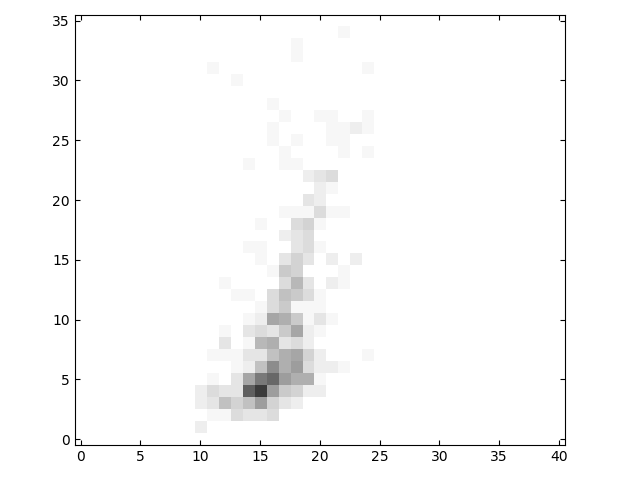

In [9]:
fig, ax = plt.subplots()
ax.imshow(Y, origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()

<IPython.core.display.Javascript object>


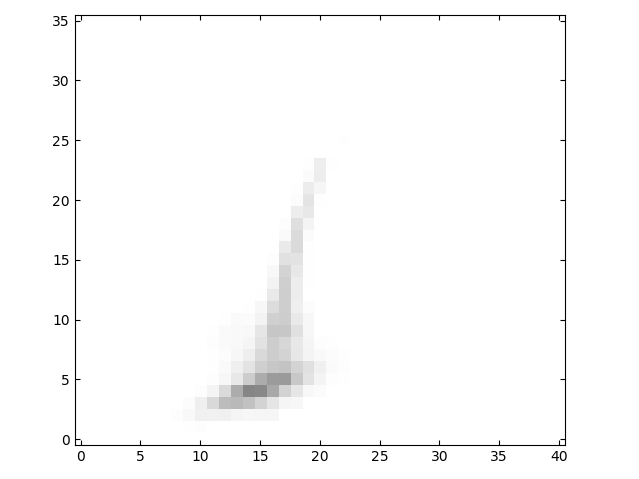

In [10]:
fig, ax = plt.subplots()
ax.imshow(model_logpar(*clipped_sol), origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()

<IPython.core.display.Javascript object>


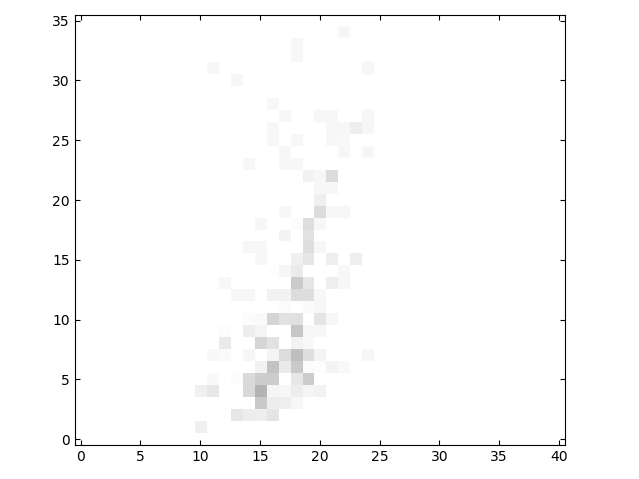

In [11]:
fig, ax = plt.subplots()
ax.imshow(Y - model_logpar(*clipped_sol), origin='lower', vmin=0., vmax=0.05, cmap='gray_r')
fig.tight_layout()

In [12]:
log_prob = lambda x: log_posterior(model_linpar, Y, S, *x)

nwalkers, ndim = 128, n_model
# pos = soln.x + 1.0*np.random.randn(nwalkers, ndim)
init = [10.0**ix if ix > plim_lo else wlim_lo for ix in soln.x]
pos = np.zeros((nwalkers, ndim))
for i in range(ndim):
    pos[:,i] = ((lambda m, s, l, u: truncnorm((l-m)/s, (u-m)/s, loc=m, scale=s))
                (init[i], 5.0e-4, plim_lo, plim_hi)).rvs(nwalkers)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob)

In [13]:
start_time = time.time()
sampler.run_mcmc(pos, 5000, progress=True);
print("----- running time : {0:.3f} sec".format(time.time()-start_time))

  0%|          | 0/5000 [00:00<?, ?it/s]/home/jlee/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [02:26<00:00, 34.20it/s]

----- running time : 146.245 sec


<IPython.core.display.Javascript object>


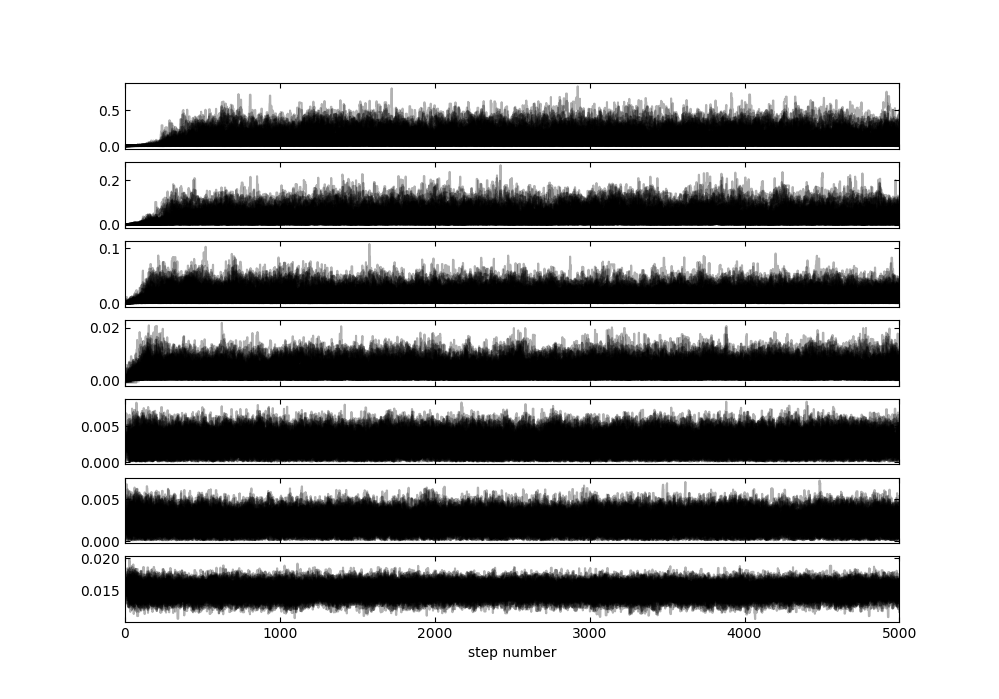

In [14]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()
labels = ['par'+str(j+1) for j in np.arange(n_model)]

for i in np.arange(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
axes[-1].set_xlabel("step number");

<IPython.core.display.Javascript object>


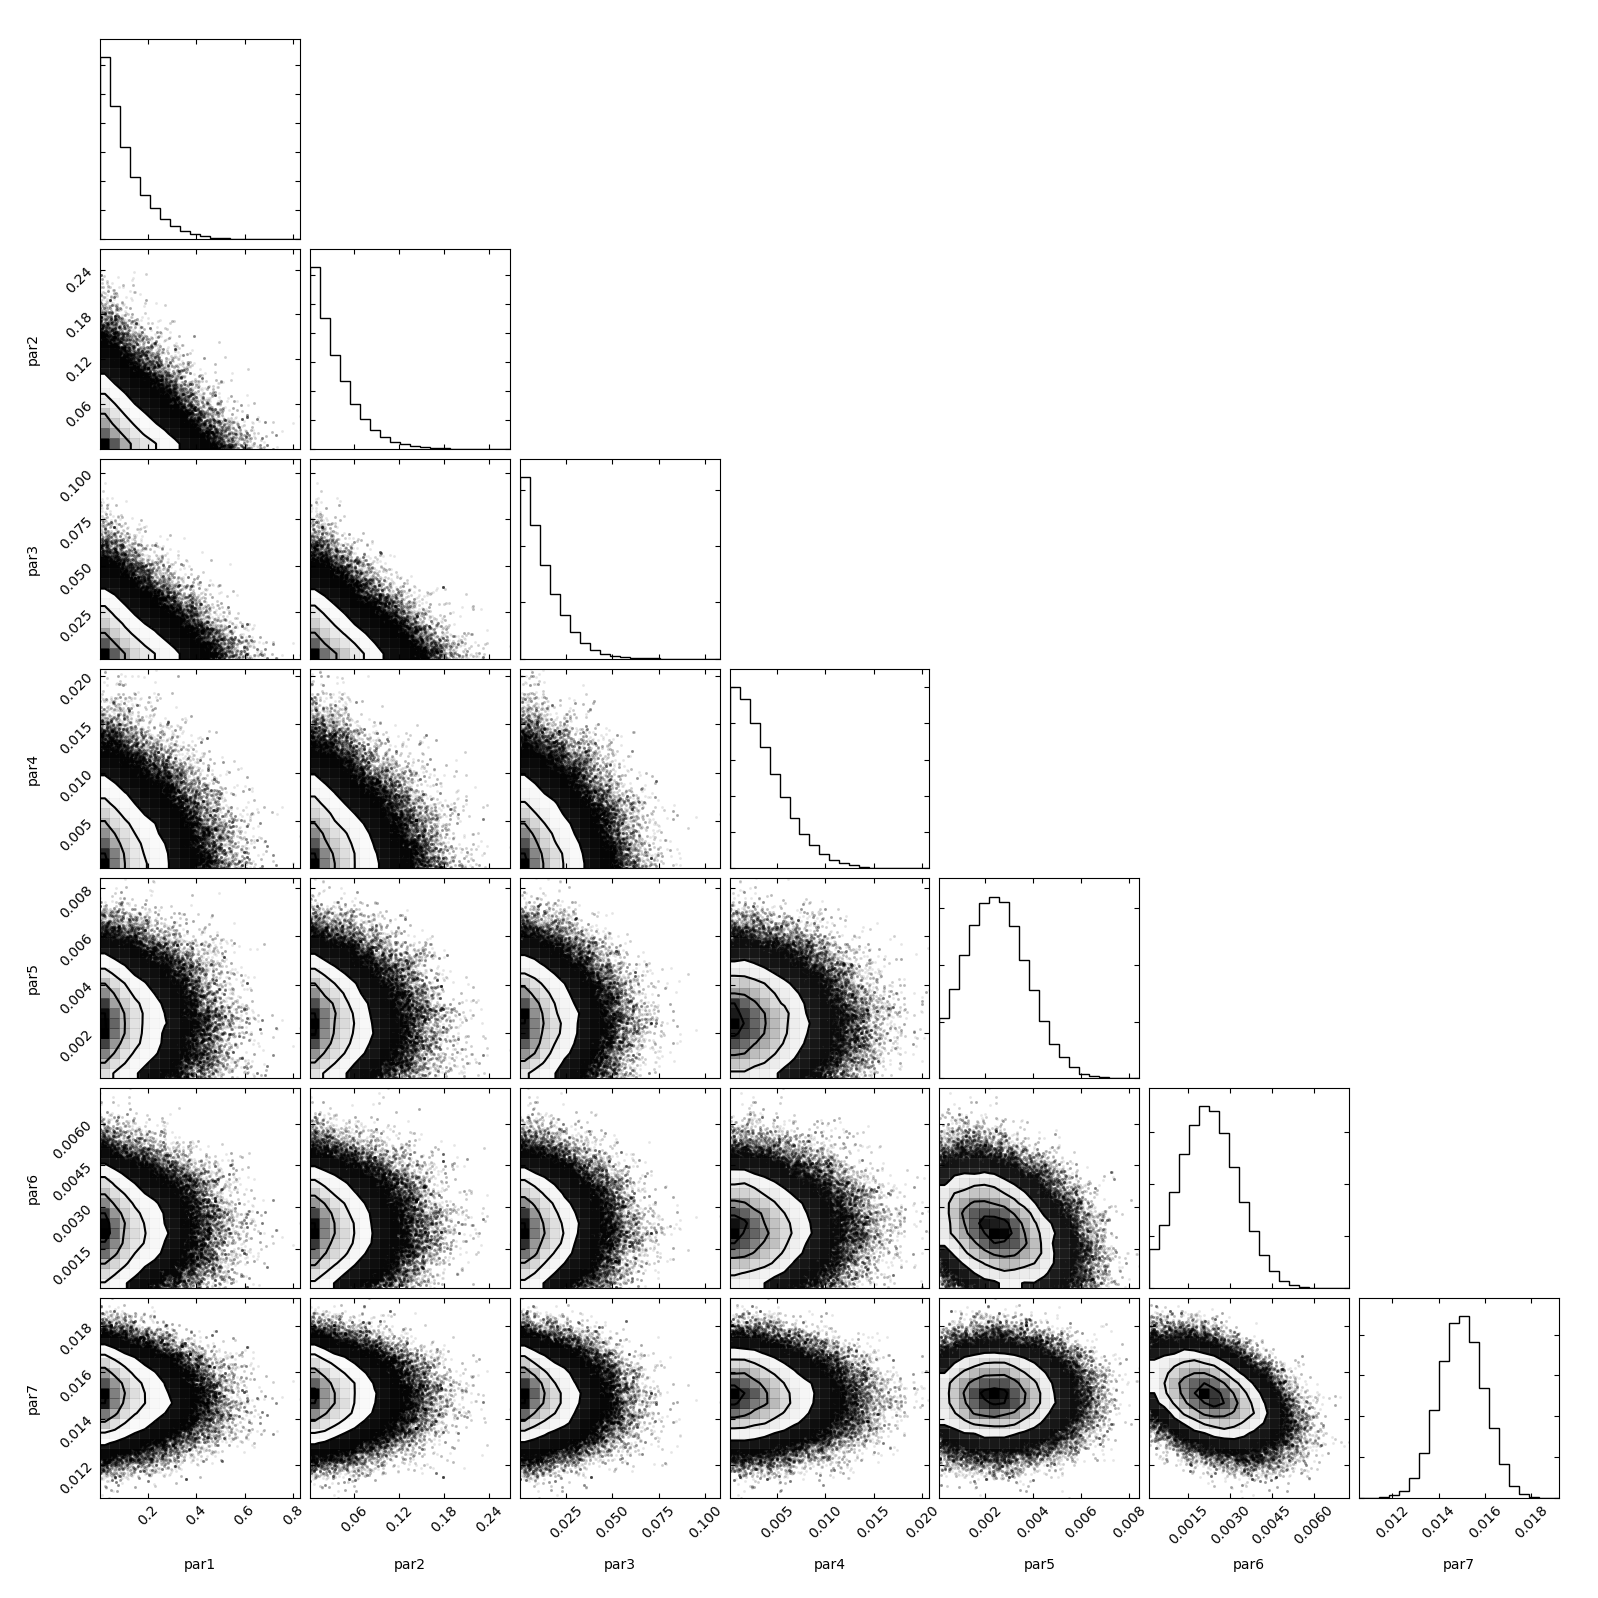

In [15]:
flat_samples = sampler.get_chain(discard=1000, flat=True)
flat_samples.shape

fig = corner.corner(flat_samples, labels=labels, truths=[*soln.x]);

In [16]:
popt, perr = [], []
for i in np.arange(ndim):
    mcmc = np.percentile(flat_samples[:, i], [50-34.15, 50, 50+34.15])
    q = np.diff(np.array([mcmc[0], mcmc[1], mcmc[2]]))
    
    popt.append(mcmc[1])
    perr.append(0.5*(mcmc[2]-mcmc[0]))

print(popt, perr)

[0.07640683169482138, 0.025011885875636956, 0.009652331480518183, 0.002955303059481237, 0.0024619212831792493, 0.002231626065420123, 0.014989802951478684] [0.08693602378507564, 0.02722941231829871, 0.010170666664895085, 0.002655731398394685, 0.0012966597928487675, 0.0010416457910368642, 0.0009790391771806965]


In [17]:
for i in np.arange(n_model):
    xx = flat_samples[:,i]
    print(f"{skew(xx[xx > 0]):.7f}")

1.4217195
1.4395041
1.3421989
1.1263444
0.3510945
0.2376274
-0.0147306
